# Simple Prophet modeling

In [33]:
pip install prophet

In [34]:
# 한글 폰트 설정
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic')

INFO:matplotlib.font_manager:generated new fontManager


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from datetime import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Stocks data & add features

In [37]:
stocks = pd.read_csv('/content/drive/My Drive/data/githublog/stock/stocks.csv', header = 0)
stocks.head()

,index,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
0,0,20190701,A000020,동화약품,N,코스피,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,9680,9840,9680,9710,31341,30581
1,1,20190701,A000080,하이트진로,N,코스피,제조업,음료 제조업,알코올음료 제조업,20550,20550,20200,20300,127186,258535
2,2,20190701,A000100,유한양행,Y,코스피,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,259000,267500,250000,251500,395757,10139357
3,3,20190701,A000120,CJ대한통운,N,코스피,운수 및 창고업,육상운송 및 파이프라인 운송업,도로 화물 운송업,136500,137000,133000,136000,62513,846100
4,4,20190701,A000140,하이트진로홀딩스,Y,코스피,금융 및 보험업,금융업,기타 금융업,9060,9190,8910,9000,7661,6896


In [38]:
print(min(stocks['기준일자']))
print(max(stocks['기준일자']))

20190701
20200728


In [39]:
# add features
stocks['가격변동'] = stocks['종목종가']-stocks['종목시가']

In [40]:
samsung = stocks[stocks['종목명']=='삼성전자']

# datetime
samsung['기준일자'] = pd.to_datetime(samsung['기준일자'], format='%Y%m%d')
samsung['월'] = samsung['기준일자'].dt.month
samsung['주'] = samsung['기준일자'].dt.weekday

# moving average
samsung['MA5'] = samsung['종목종가'].rolling(window=5,min_periods=1).mean()
samsung['MA30'] = samsung['종목종가'].rolling(window=30,min_periods=1).mean()
samsung['MA60'] = samsung['종목종가'].rolling(window=60,min_periods=1).mean()
samsung['MA120'] = samsung['종목종가'].rolling(window=120,min_periods=1).mean()

### Candle chart 

In [41]:
cmap = list(map(lambda x: 'blue' if x>0 else 'red',samsung['가격변동']))

def plot_trend(df,name):
  from matplotlib import gridspec

  plt.figure(figsize=(20, 8))                  
  gs = gridspec.GridSpec(nrows=2, ncols=1,    
                       height_ratios=[5, 1]) 

##############################################
  plt.subplot(gs[0])                         
  # 캔들스틱 그리는 코드 넣을 자리 
  plt.subplot(gs[0])
  plt.title(f'{name} 주식캔들',fontsize=15)
  plt.bar(df['기준일자'],height=df['종목종가']-df['종목시가'],bottom=df['종목시가'],color=cmap)
  plt.vlines(df['기준일자'],df['종목저가'],df['종목고가'],colors=cmap)
  sns.lineplot(df['기준일자'],df['MA5'],color='orange',label='MA5',alpha=0.5);sns.lineplot(df['기준일자'],df['MA30'],color='green',label='MA30',alpha=0.5);
  sns.lineplot(df['기준일자'],df['MA60'],color='purple',label='MA60',alpha=0.5);sns.lineplot(df['기준일자'],df['MA120'],color='pink',label='MA120',alpha=0.5);
  plt.ylabel('주가');

  plt.subplot(gs[1])                       
  sns.lineplot(data=df,x='기준일자',y='거래량',color='green')
  plt.title(f'{name} 거래량 변동 추이',fontsize=15)

##############################################

  plt.subplots_adjust(wspace = 0, hspace = 0)  
  plt.show()

def plot_trend_ver2(df,name):
  from matplotlib import gridspec

  plt.figure(figsize=(20, 8))                 
  gs = gridspec.GridSpec(nrows=2, ncols=1,    
                       height_ratios=[5, 1]) 

##############################################
  plt.subplot(gs[0])                         
  # 캔들스틱 그리는 코드 넣을 자리 
  plt.subplot(gs[0])
  plt.title(f'{name} 주식캔들',fontsize=15)
  plt.bar(df['기준일자'],height=df['종목종가']-df['종목시가'],bottom=df['종목시가'],color=cmap)
  plt.vlines(df['기준일자'],df['종목저가'],df['종목고가'],colors=cmap)
  sns.lineplot(df['기준일자'],df['MA5'],color='orange',label='MA5',alpha=0.5);sns.lineplot(df['기준일자'],df['MA30'],color='green',label='MA30',alpha=0.5);
  sns.lineplot(df['기준일자'],df['MA60'],color='purple',label='MA60',alpha=0.5);sns.lineplot(df['기준일자'],df['MA120'],color='pink',label='MA120',alpha=0.5);
  plt.ylabel('주가');

  plt.subplot(gs[1])                       
  sns.lineplot(data=df,x='기준일자',y='거래량',color='green')
  plt.title(f'{name} 거래량 변동 추이',fontsize=15)

##############################################

  plt.subplots_adjust(wspace = 0, hspace = 0)  # 구획(subplot) 간의 간격을 없앤다.
  plt.show()

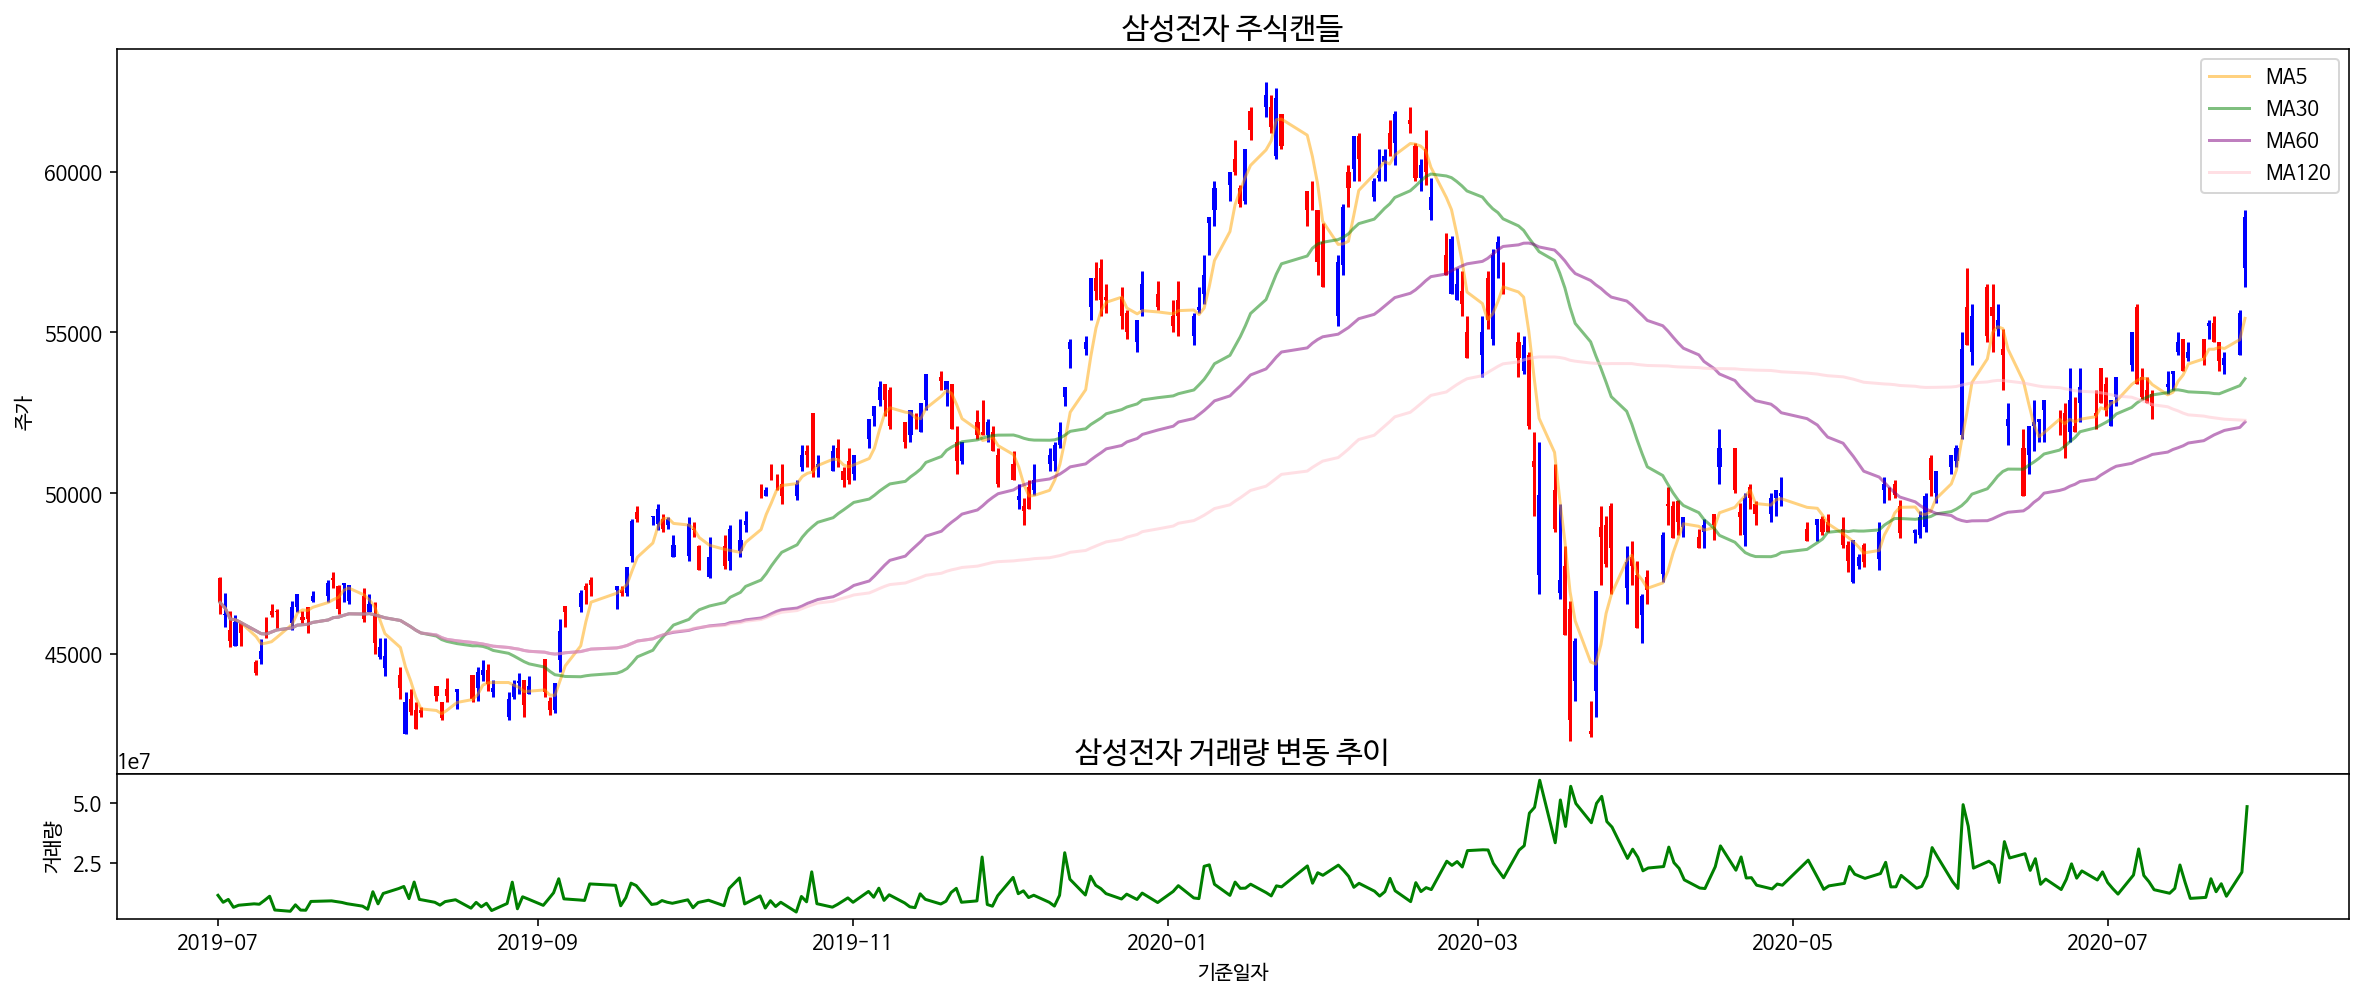

In [42]:
plot_trend(samsung,'삼성전자')

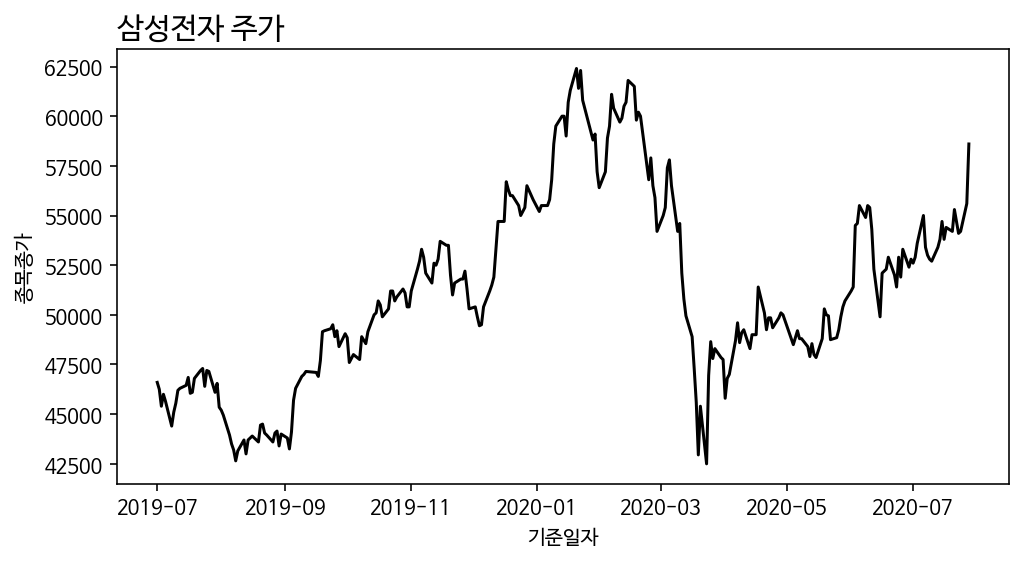

In [43]:
plt.figure(figsize= (8,4))
sns.lineplot(data=samsung,x='기준일자',y='종목종가', color = 'black');
plt.title('삼성전자 주가', fontsize = 15, loc='left')
plt.show()

## Prophet Modeling

In [44]:
df = pd.DataFrame(
    {'ds':samsung['기준일자'],
     'y':samsung['종목종가']
    }
).reset_index()
df = df.iloc[:,1:]
df.head()

,ds,y
0,2019-07-01,46600
1,2019-07-02,46250
2,2019-07-03,45400
3,2019-07-04,46000
4,2019-07-05,45650


In [45]:
start = datetime(2020,7,1)

# train & test(prediction)
train = df[df['ds']<start]
test = df[df['ds']>=start]

print(train.shape)
print(test.shape)

(248, 2)
(20, 2)


### Model 1: Simple prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


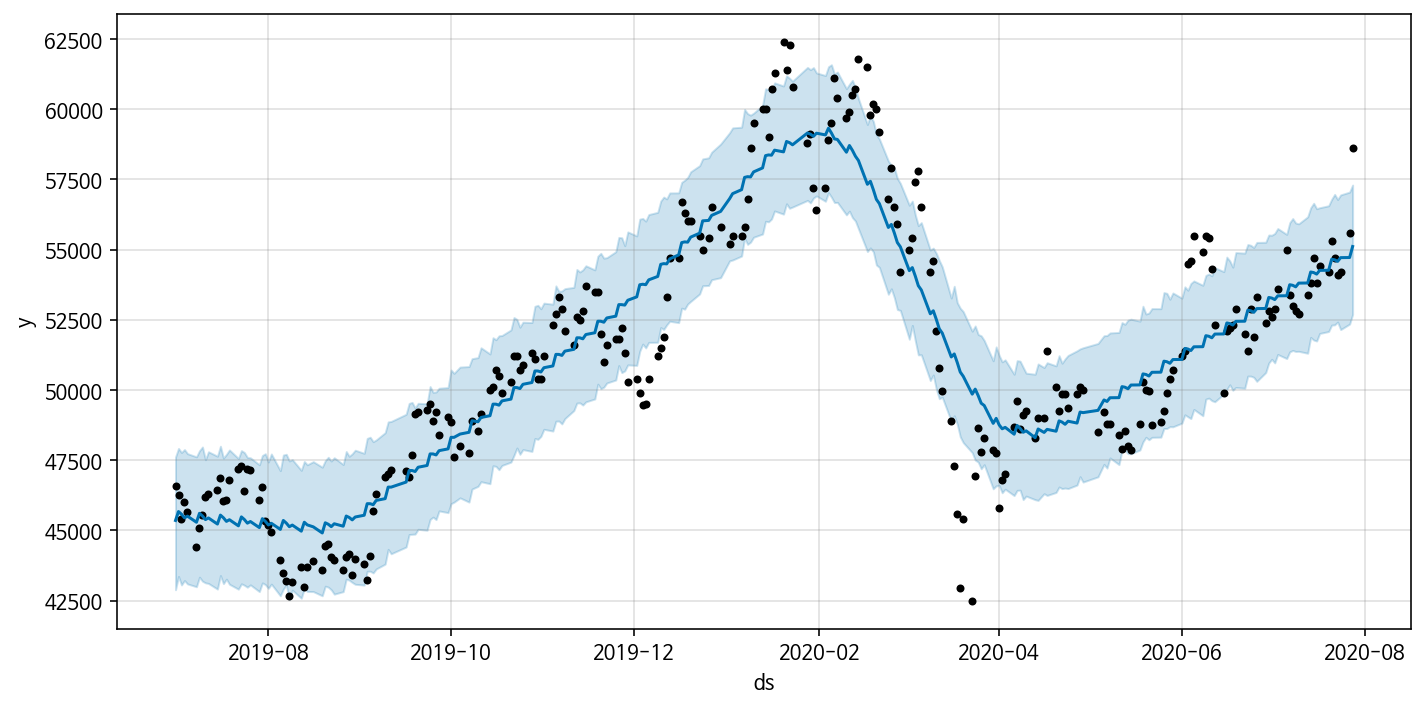

In [46]:
# 기본 prophet
model = Prophet()
model.fit(df)

forecast = model.predict(df)
fig, ax = plt.subplots(figsize=(10,5))
model.plot(forecast,ax=ax)
plt.show()

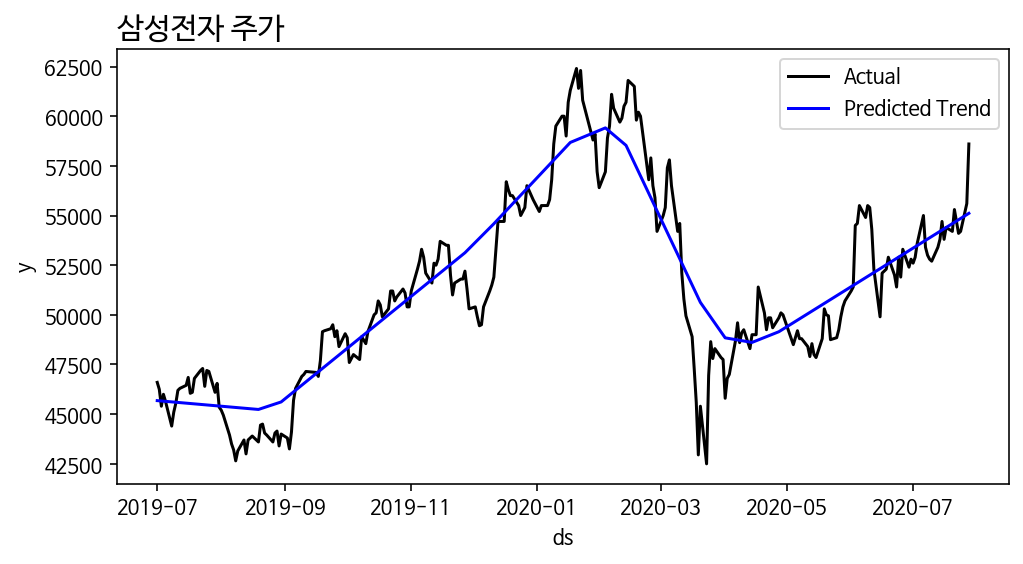

In [47]:
plt.figure(figsize= (8,4))
sns.lineplot(data=df,x='ds',y='y', color = 'black',label='Actual');
sns.lineplot(data=forecast,x='ds',y='trend', color = 'blue',label='Predicted Trend');
plt.title('삼성전자 주가', fontsize = 15, loc='left')
plt.show()

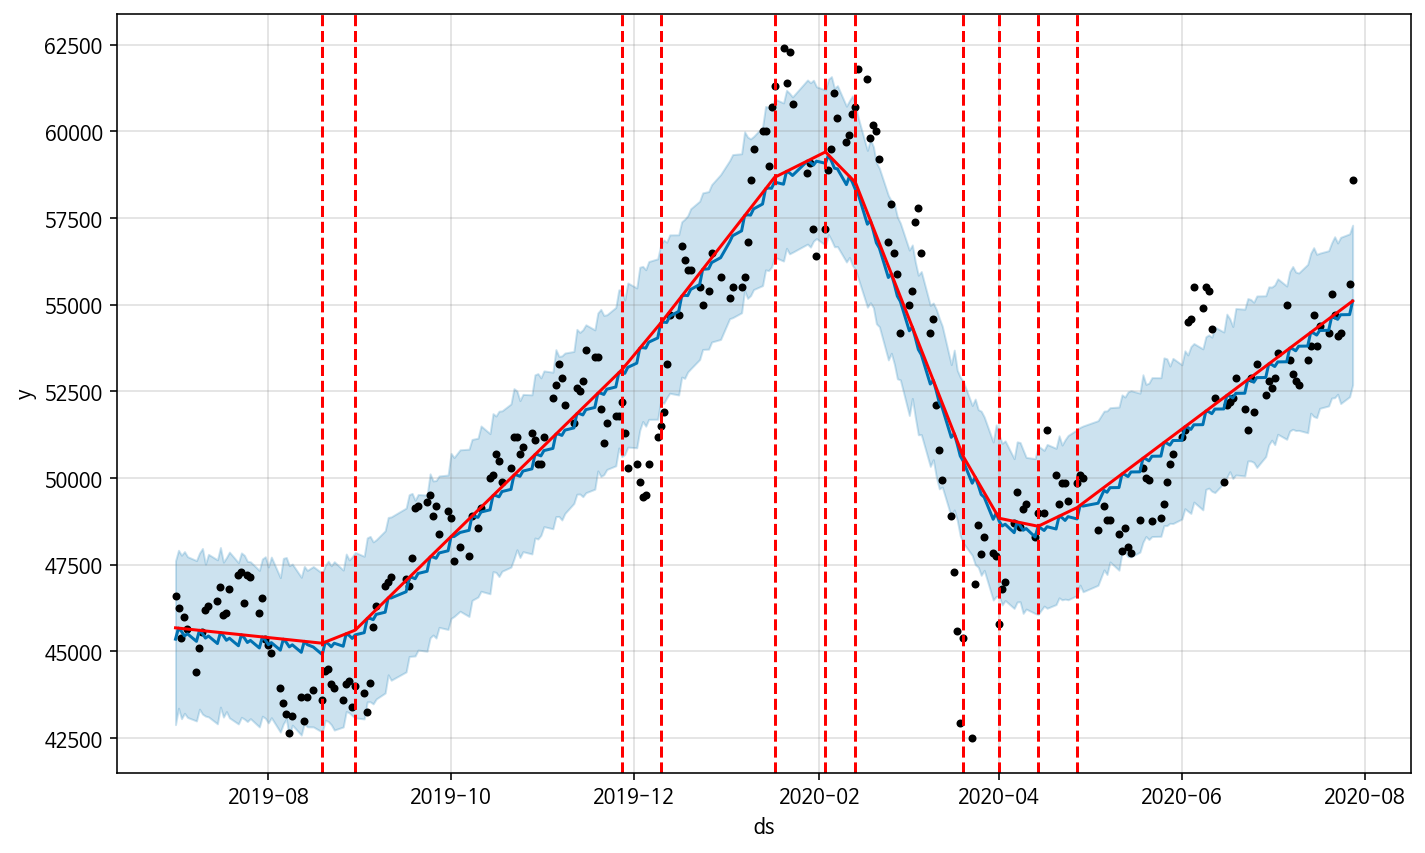

In [48]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Model 2: Trend change points 조정

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


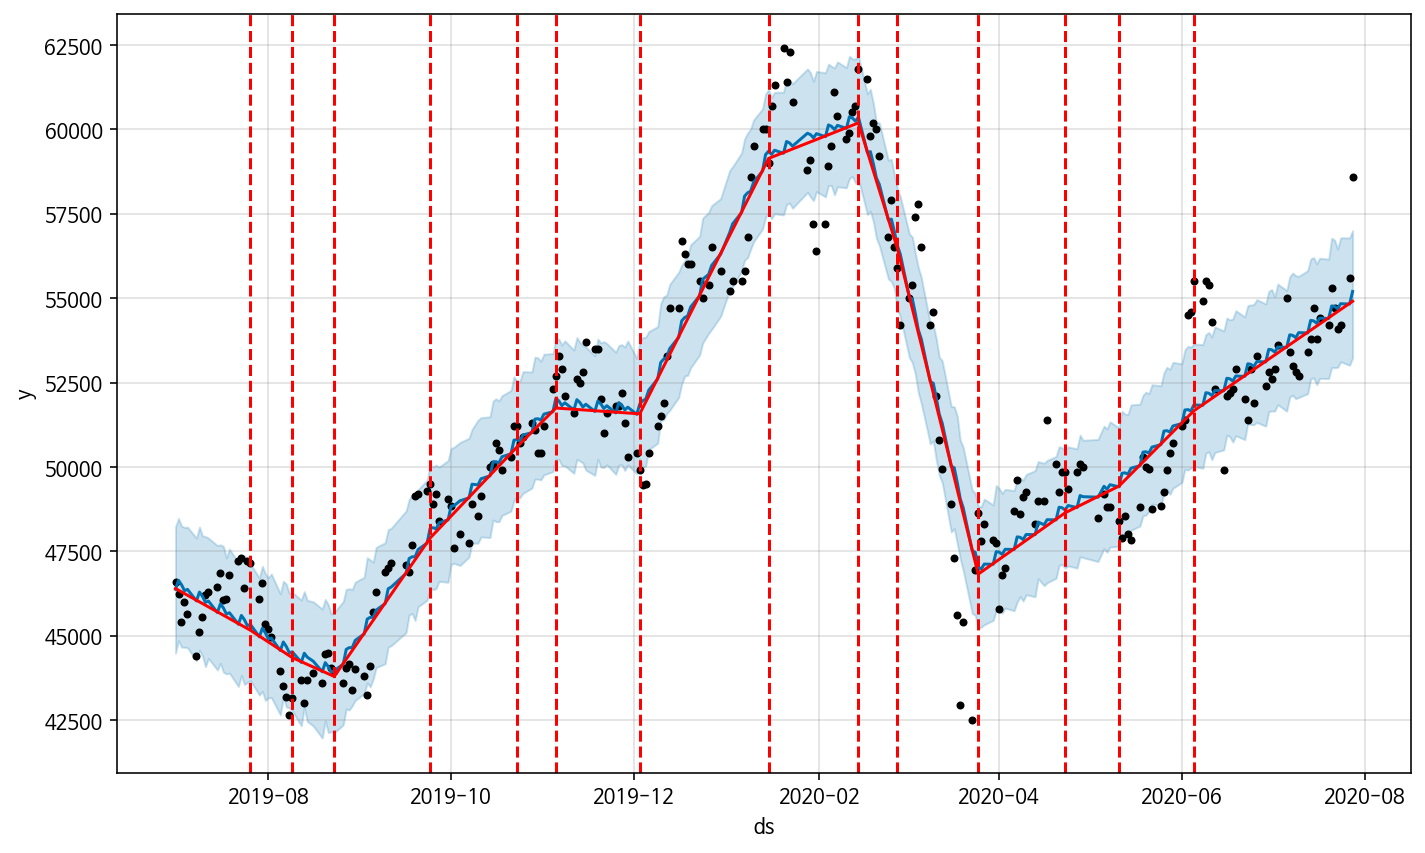

In [49]:
model2 = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.2)
model2.fit(df)
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), model2, forecast2)

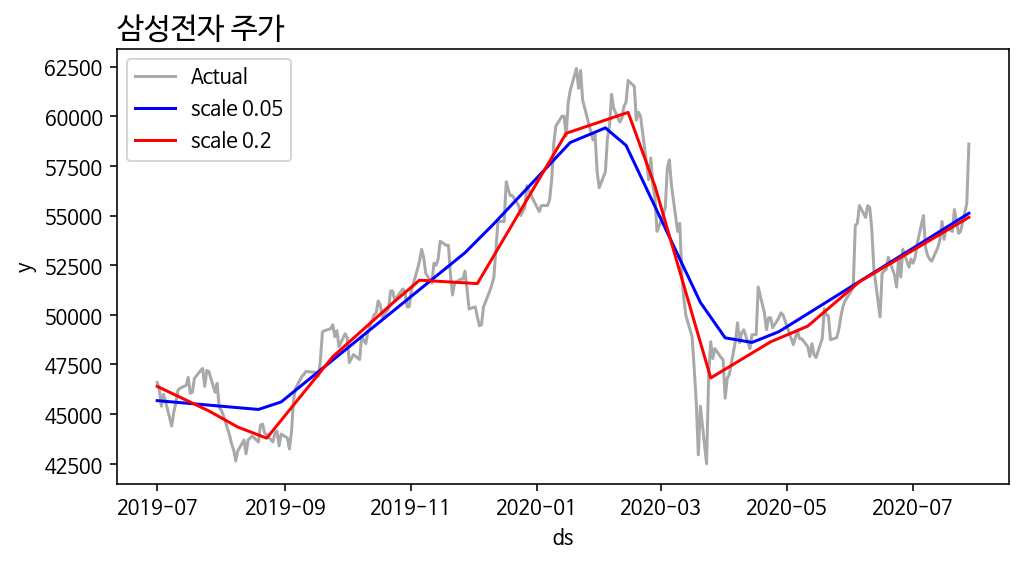

In [50]:
plt.figure(figsize= (8,4))
sns.lineplot(data=df,x='ds',y='y', color = 'darkgrey',label='Actual');
sns.lineplot(data=forecast,x='ds',y='trend', color = 'blue',label='scale 0.05');
sns.lineplot(data=forecast2,x='ds',y='trend', color = 'red',label='scale 0.2');
plt.title('삼성전자 주가', fontsize = 15, loc='left')
plt.show()

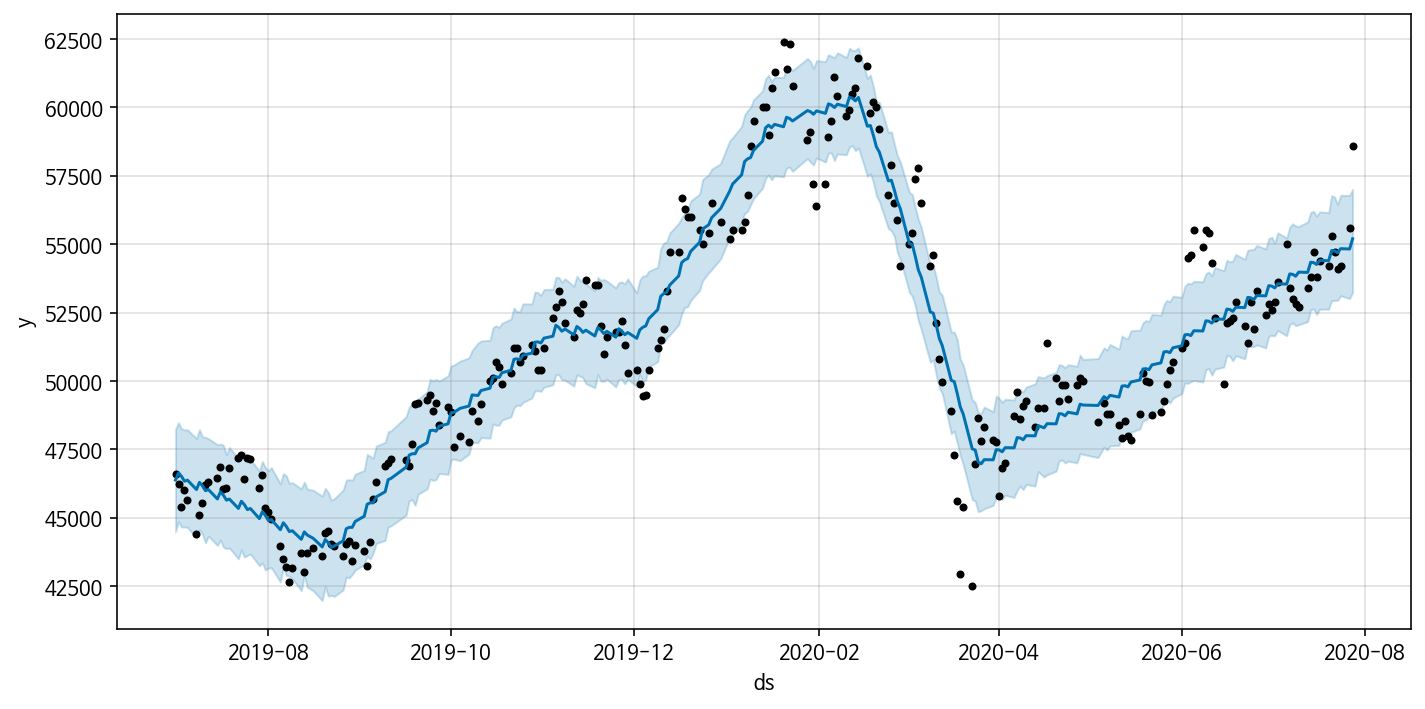

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
model2.plot(forecast2,ax=ax)
plt.show()

### Model 3: Add monthly seasonality

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


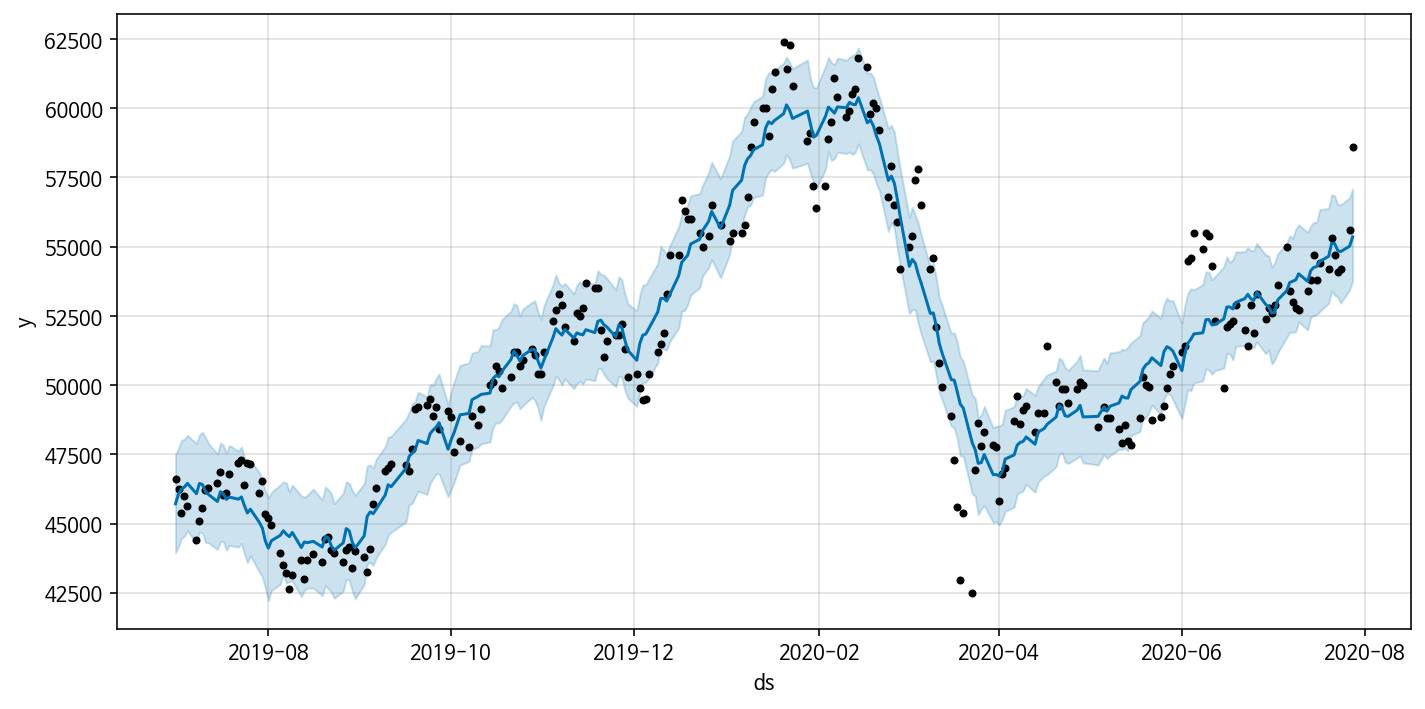

In [52]:
# add monthly seasonality
model3 = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.2)
model3.add_seasonality(name='monthly',period=30.5,fourier_order=5)

model3.fit(df)
forecast3 = model3.predict(df)
fig, ax = plt.subplots(figsize=(10,5))
model3.plot(forecast3,ax=ax)
plt.show()

### Model 4: Make seasonality mode 'multiplicatve'

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


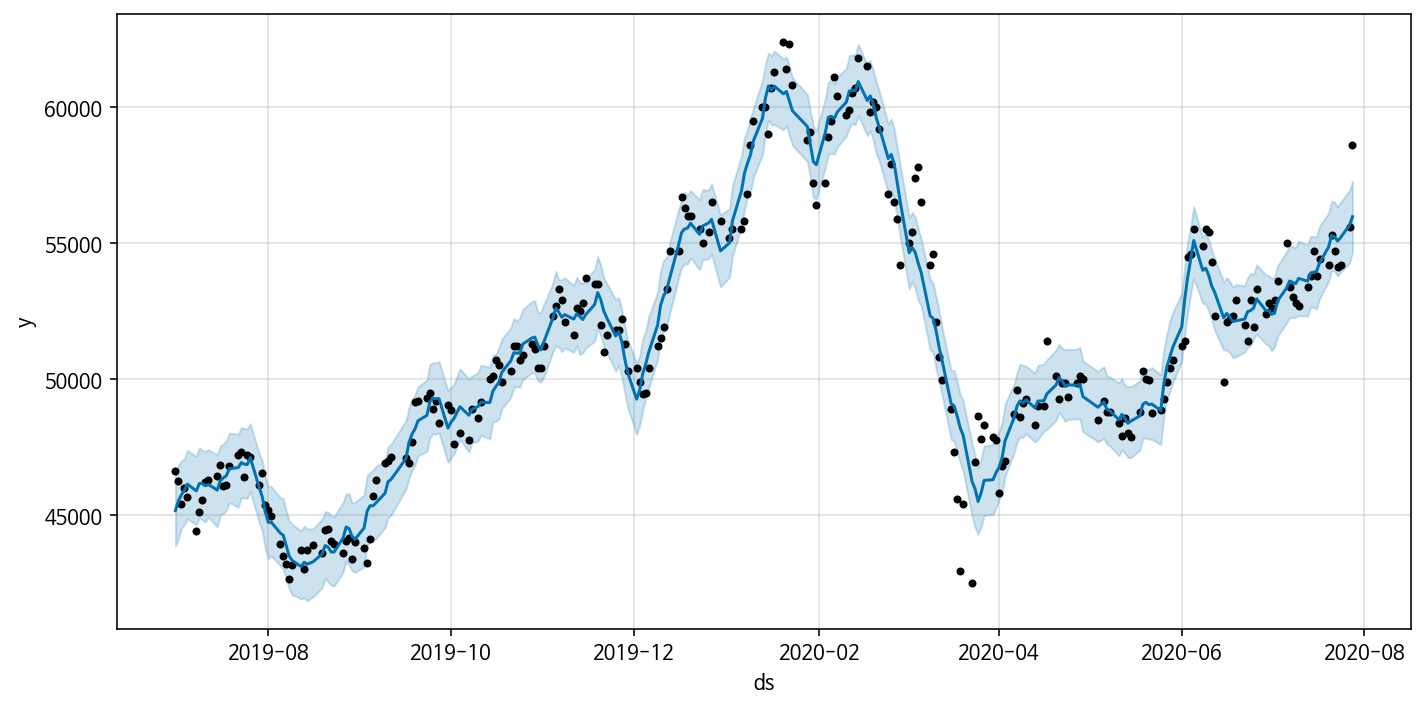

In [53]:
# multiplicative
model4 = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.3, seasonality_mode='multiplicative')
model4.add_seasonality(name='monthly',period=30.5,fourier_order=5)

model4.fit(df)
forecast4 = model4.predict(df)
fig, ax = plt.subplots(figsize=(10,5))
model4.plot(forecast4,ax=ax)
plt.show()

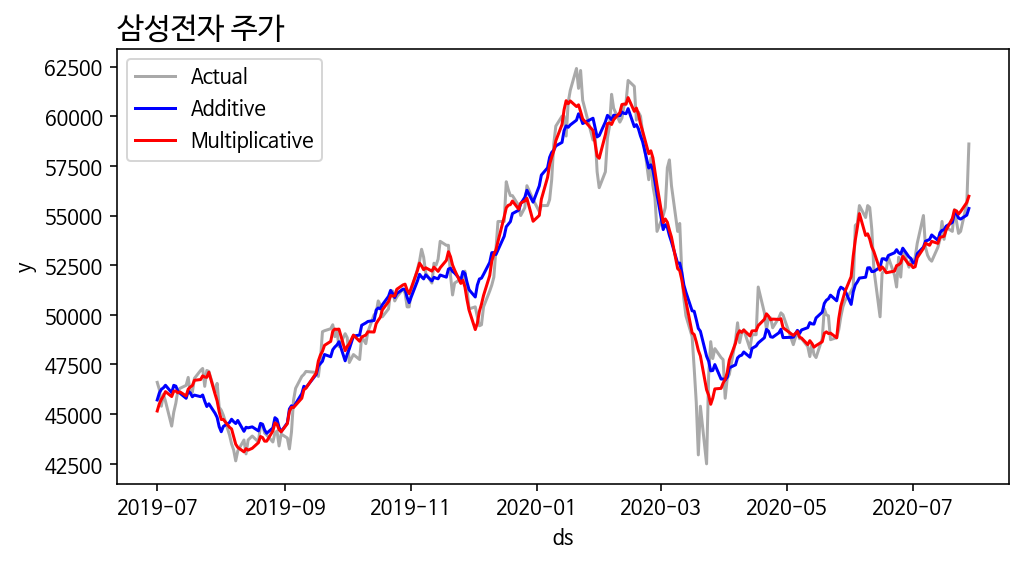

In [54]:
plt.figure(figsize= (8,4))
sns.lineplot(data=df,x='ds',y='y', color = 'darkgrey',label='Actual');
sns.lineplot(data=forecast3,x='ds',y='yhat', color = 'blue',label='Additive');
sns.lineplot(data=forecast4,x='ds',y='yhat', color = 'red',label='Multiplicative');
plt.title('삼성전자 주가', fontsize = 15, loc='left')
plt.show()

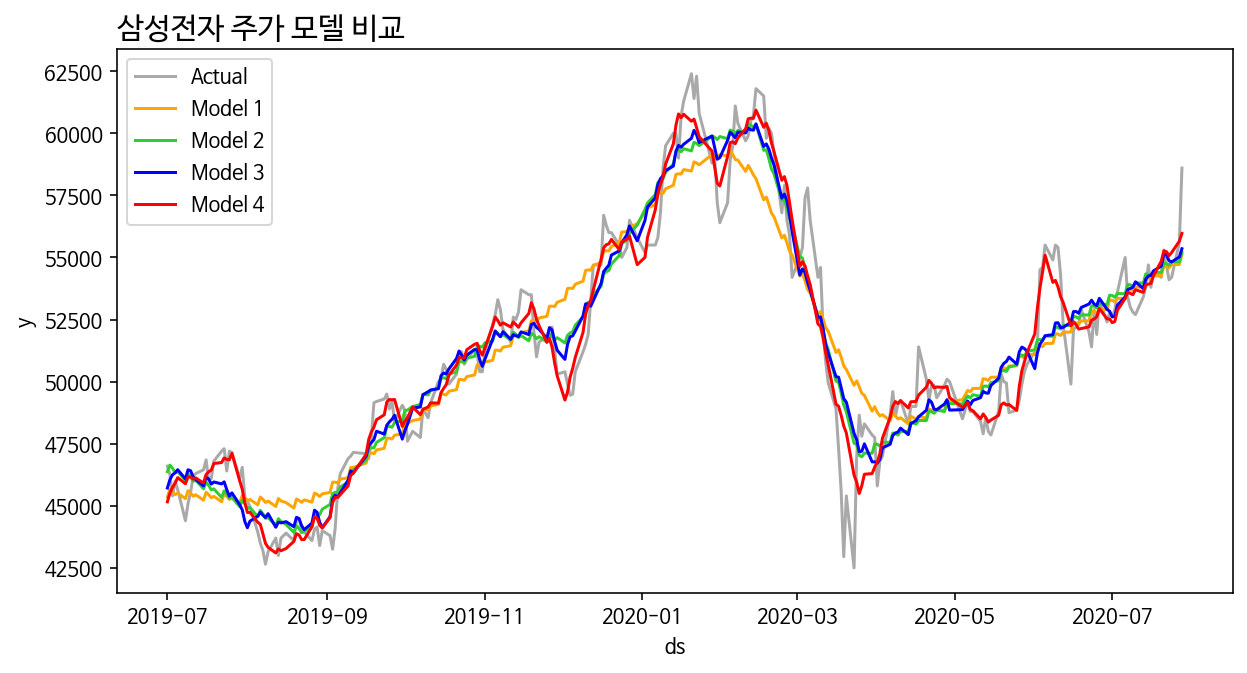

In [55]:
plt.figure(figsize= (10,5))
sns.lineplot(data=df,x='ds',y='y', color = 'darkgrey',label='Actual');
sns.lineplot(data=forecast,x='ds',y='yhat', color = 'orange',label='Model 1');
sns.lineplot(data=forecast2,x='ds',y='yhat', color = 'limegreen',label='Model 2');
sns.lineplot(data=forecast3,x='ds',y='yhat', color = 'blue',label='Model 3');
sns.lineplot(data=forecast4,x='ds',y='yhat', color = 'red',label='Model 4');
plt.title('삼성전자 주가 모델 비교', fontsize = 15, loc='left')
plt.show()

## Evaluation

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


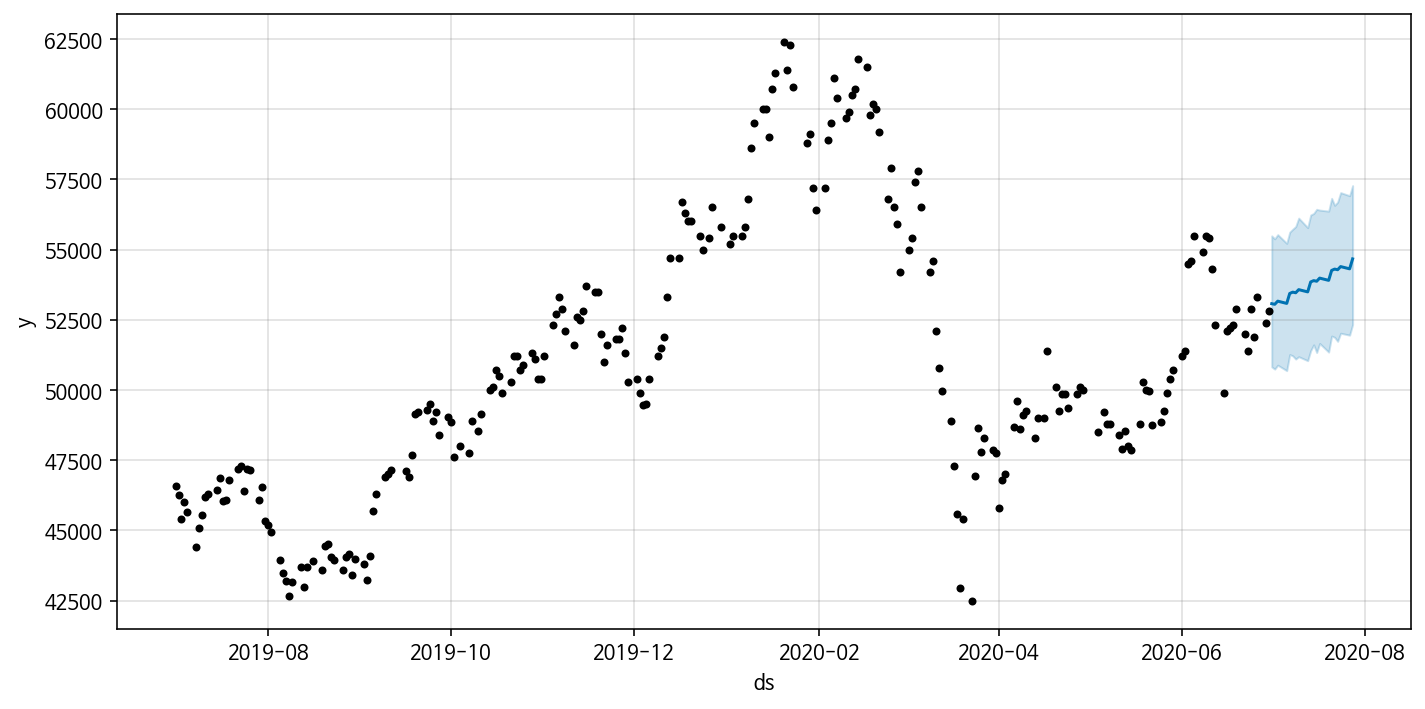

In [56]:
model1 = Prophet()
model1.fit(train)
forecast1 = model1.predict(test.iloc[:,:-1])
fig, ax = plt.subplots(figsize=(10,5))
model1.plot(forecast1,ax=ax)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


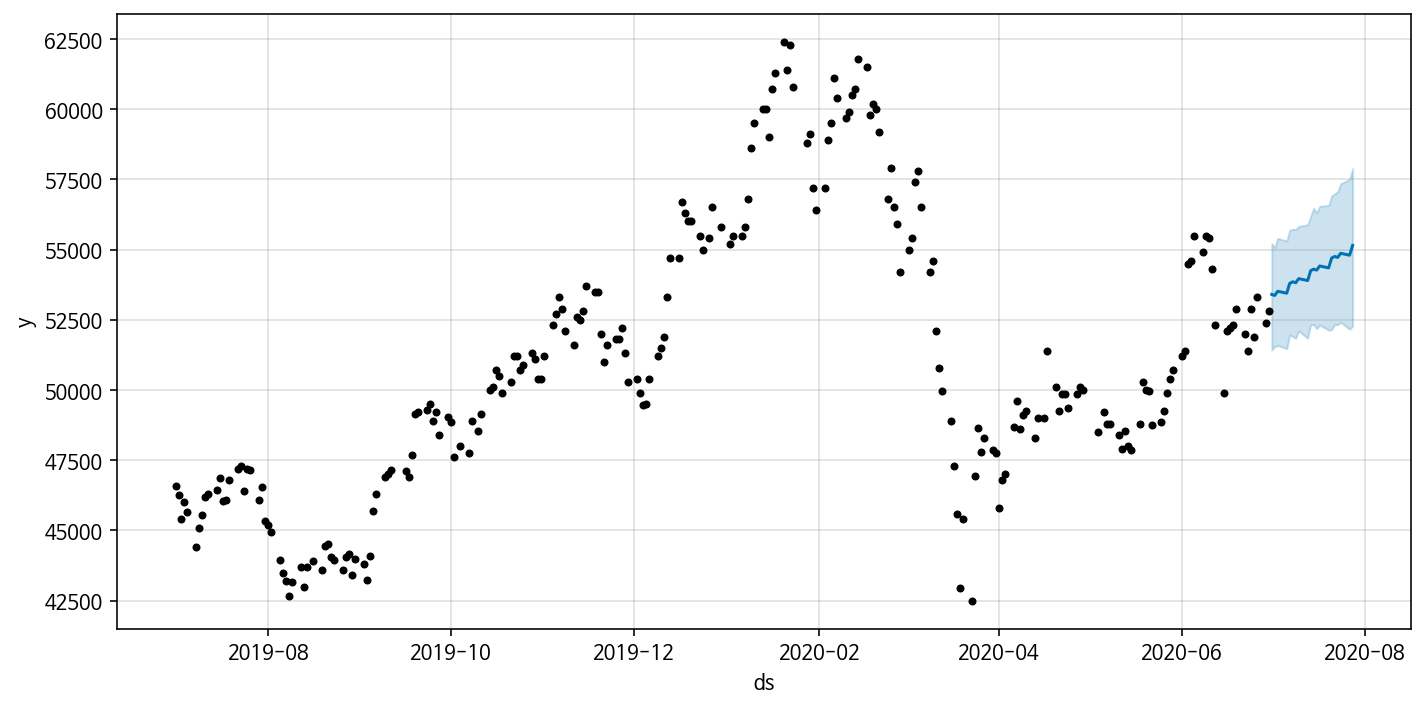

In [57]:
model2 = Prophet(changepoint_range=0.8, changepoint_prior_scale= 0.2)
model2.fit(train)
forecast2 = model2.predict(test.iloc[:,:-1])
fig, ax = plt.subplots(figsize=(10,5))
model2.plot(forecast2,ax=ax)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


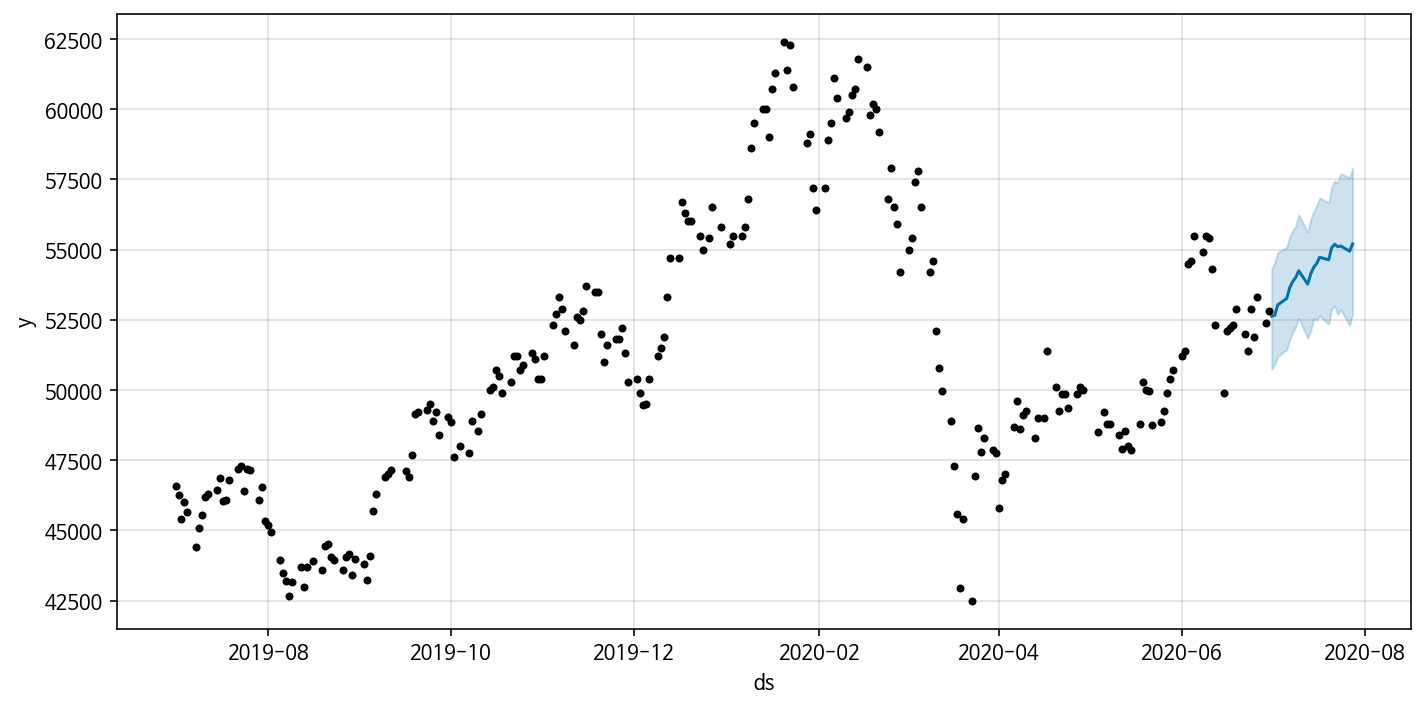

In [58]:
model3 = Prophet(changepoint_range=0.8, changepoint_prior_scale= 0.2)
model3.add_seasonality(name='monthly',period=30.5,fourier_order=5)

model3.fit(train)
forecast3 = model3.predict(test.iloc[:,:-1])
fig, ax = plt.subplots(figsize=(10,5))
model3.plot(forecast3,ax=ax)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


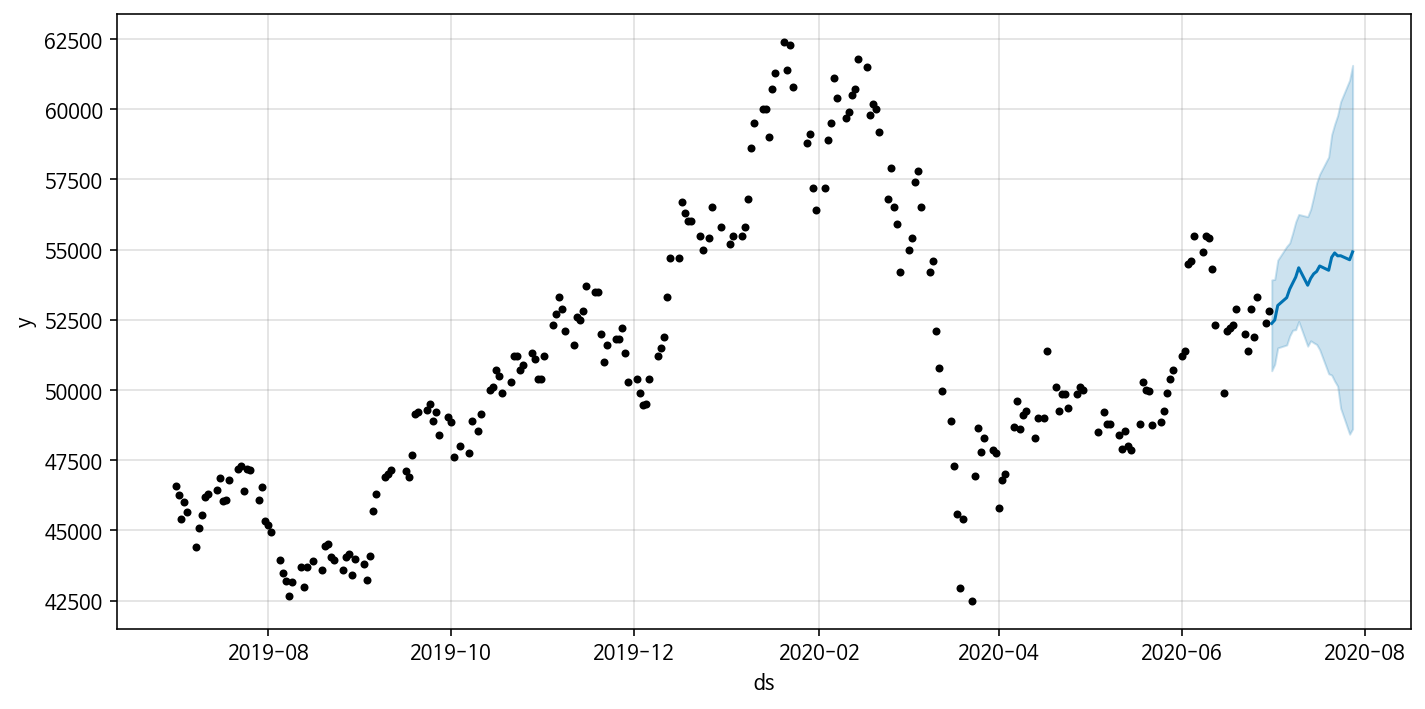

In [59]:
model4 = Prophet(changepoint_range=0.8, changepoint_prior_scale= 0.2, seasonality_mode='multiplicative')
model4.add_seasonality(name='monthly',period=30.5,fourier_order=5)

model4.fit(train)
forecast4 = model4.predict(test.iloc[:,:-1])

fig, ax = plt.subplots(figsize=(10,5))
model4.plot(forecast4,ax=ax)
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def get_evals(model,true_value, forecast):
  MAE = mean_absolute_error(true_value,forecast)
  RMSE = np.sqrt(mean_squared_error(true_value,forecast))
  print('MAE: ', np.round(MAE,4))
  print('RMSE: ', np.round(RMSE,4))

In [61]:
get_evals(model1,test['y'],forecast1['yhat'])

MAE:  690.0053
RMSE:  1115.7144


In [62]:
get_evals(model2,test['y'],forecast2['yhat'])

MAE:  730.4777
RMSE:  1034.1343


In [63]:
get_evals(model3,test['y'],forecast3['yhat'])

MAE:  782.0135
RMSE:  1080.2296


In [64]:
get_evals(model4,test['y'],forecast4['yhat'])

MAE:  751.7987
RMSE:  1110.7235
